In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

%config InlineBackend.figure_formats = ["svg"]
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)

PATH_DATA = "data"
PATH_R_OUTPUT = "output"

## PCA

In [2]:
# read rlog-transformed count data and sample metadata
rlog_data = pd.read_csv(
    os.path.join(PATH_R_OUTPUT, "./counts.rlog.txt"), sep="\t", index_col=0
)
samples = pd.read_csv(os.path.join(PATH_DATA, "./samples.txt"), sep="\t", index_col=0)

In [3]:
# subset top 500 highly variable genes by rlog variance
idx = rlog_data.var(axis=1).sort_values(ascending=False).index[:500]
variable_subset = rlog_data.loc[idx]

In [4]:
pca = PCA(svd_solver="full")

# compute PCA and variance explained
X = variable_subset.values.T
Y = pca.fit_transform(X)
transformed = pd.DataFrame(Y, index=variable_subset.columns)
variances = pca.explained_variance_ratio_

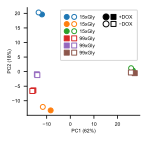

In [5]:
# plot samples PC1 and PC2
#   color by clone
#   symbol by repeat length (circles for 15x, squares for 99x)
#   fill by DOX (filled for +DOX, empty for -DOX)


fig, ax = plt.subplots(figsize=(2, 1.9))

# marker style mapping
color = {
    "c15x9": "C0",
    "c15x10": "C1",
    "c15x12": "C2",
    "c99x5": "C3",
    "c99x8": "C4",
    "c99x26": "C5",
}
marker = {"15x": "o", "99x": "s"}
fill = {"D0": True, "D14": False}

# plot 15x and 99x separately since scatter() handles only one type of marker symbol
for r in ("15x", "99x"):
    # index of 15x or 99x samples
    idx = samples[samples["repeats"] == r].index
    ax.scatter(
        transformed.loc[idx][0],
        transformed.loc[idx][1],
        s=25,
        edgecolors=samples.loc[idx]["clone"].map(color).to_list(),
        marker=marker[r],
        facecolors=samples.loc[idx]
        .apply(lambda x: color[x["clone"]] if fill[x["day"]] else "w", axis=1)
        .to_list(),
    )

# generate legend symbols and labels
plt.legend(
    # filled and empty markers for each clone by color
    [
        (
            mlines.Line2D([], [], color=f"C{i}", marker=m, linestyle="none", ms=5),
            mlines.Line2D(
                [], [], color=f"C{i}", marker=m, linestyle="none", mfc="none", ms=5
            ),
        )
        for i, m in zip(range(6), ["o"] * 3 + ["s"] * 3)
    ]
    +
    # circle and square marker for each DOX status
    [
        (
            mlines.Line2D([], [], color="k", marker="o", linestyle="none"),
            mlines.Line2D([], [], color="k", marker="s", linestyle="none", ms=5),
        ),
        (
            mlines.Line2D([], [], color="k", marker="o", linestyle="none", mfc="none"),
            mlines.Line2D(
                [], [], color="k", marker="s", linestyle="none", mfc="none", ms=5
            ),
        ),
    ]
    +
    # empty space
    [mlines.Line2D([], [], linestyle="none")] * 4,
    # corresponding labels
    ["15xGly"] * 3 + ["99xGly"] * 3 + ["+DOX", "−DOX"] + [None] * 4,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1, 1),
    loc="upper right",
    borderpad=1,
    ncol=2,
)

sns.despine()
plt.xlabel(f"PC1 ({variances[0] * 100:.0f}%)", labelpad=2)
plt.ylabel(f"PC2 ({variances[1] * 100:.0f}%)", labelpad=0)
plt.tight_layout()

## GO enrichment analysis

In [3]:
deg_15_data = pd.read_csv(
    os.path.join(PATH_R_OUTPUT, "./repeats15x.dayD14.txt"), sep="\t", index_col=0
)
deg_99_data = pd.read_csv(
    os.path.join(PATH_R_OUTPUT, "./repeats99x.dayD14.txt"), sep="\t", index_col=0
)
deg_15_data = deg_15_data[deg_15_data["padj"].notna()]
deg_99_data = deg_99_data[deg_99_data["padj"].notna()]

In [4]:
# load ensembl ID mapping
ensembl2ncbi = (
    pd.read_csv(os.path.join(PATH_DATA, "ensembl2ncbi.txt"), sep="\t")
    .set_index("Gene stable ID")
    .dropna()["NCBI gene (formerly Entrezgene) ID"]
    .to_dict()
)

# Load GO graph
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag

obo_fname = download_go_basic_obo()
obodag = GODag(obo_fname)

# load gene annotations
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader

gene2go_fname = download_ncbi_associations()
objanno = Gene2GoReader(gene2go_fname, taxids=[9606])
ns2assoc = objanno.get_ns2assc()
for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-01-01) 46,739 Terms
  EXISTS: gene2go
HMS:0:00:02.827029 339,369 annotations, 20,700 genes, 18,988 GOs, 1 taxids READ: gene2go 
MF 18,198 annotated human genes
CC 19,397 annotated human genes
BP 18,406 annotated human genes


In [7]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS


def run_go(df_genes, filter_p=0.05, filter_lfc=0):
    background = set(
        map(ensembl2ncbi.get, df_genes.index[df_genes.index.isin(ensembl2ncbi)])
    )
    genes_up = df_genes[
        (df_genes["padj"] < filter_p) & (df_genes["log2FoldChange"] > filter_lfc)
    ]
    genes_down = df_genes[
        (df_genes["padj"] < filter_p) & (df_genes["log2FoldChange"] < -filter_lfc)
    ]
    print(f"background set: {len(background)} detected transcripts")
    print(f"{len(genes_up)} up; {len(genes_down)} down")

    goeaobj = GOEnrichmentStudyNS(
        background,
        ns2assoc,
        obodag,
        propagate_counts=True,
        alpha=0.01,
        methods=["fdr_bh"],
    )
    res_up = goeaobj.run_study(
        set(map(ensembl2ncbi.get, genes_up.index[genes_up.index.isin(ensembl2ncbi)]))
    )
    res_down = goeaobj.run_study(
        set(
            map(ensembl2ncbi.get, genes_down.index[genes_down.index.isin(ensembl2ncbi)])
        )
    )

    def res2df(res):
        GO_results = []
        for rec in res:
            GO_results.append(
                [
                    rec.goterm.name,
                    rec.NS,
                    rec.study_count,
                    rec.pop_count,
                    (rec.study_count / rec.study_n) / (rec.pop_count / rec.pop_n),
                    rec.p_fdr_bh,
                    rec.p_uncorrected,
                ]
            )
        GO_results = pd.DataFrame(
            GO_results,
            columns=["term", "namespace", "count", "size", "ratio", "p_adj", "p"],
        )
        return GO_results

    return tuple(map(res2df, (res_up, res_down)))

In [8]:
res_15_up, res_15_down = run_go(deg_15_data)
res_99_up, res_99_down = run_go(deg_99_data)

background set: 21627 detected transcripts
881 up; 694 down

Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 73% 15,756 of 21,627 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 77% 16,604 of 21,627 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 75% 16,129 of 21,627 population items found in association

Runing BP Ontology Analysis: current study set of 741 IDs.
 90%    665 of    741 study items found in association
100%    741 of    741 study items found in population(21627)
Calculating 15,306 uncorrected p-values using fisher_scipy_stats
  15,306 terms are associated with 15,756 of 21,627 population items
   4,553 terms are associated with    665 of    741 study items
  METHOD fdr_bh:
     212 GO terms found significant (< 0.01=alpha) (208 enriched +   4 purified): statsmodels fdr_bh
     665 study items associated with signif

In [11]:
# shortened versions of GO terms to display in figure
GO_abbrev = {
    "enzyme-linked receptor protein signaling pathway": "enzyme-linked receptor protein signaling",
    "maturation of SSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)": "maturation of SSU-rRNA from rRNA",
    "maturation of LSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)": "maturation of LSU-rRNA from rRNA",
    "regulation of protein localization to Cajal body": "regulation of localization to Cajal body",
    "positive regulation of protein localization to Cajal body": "pos. regulation of localization to Cajal body",
    "protein localization to CENP-A containing chromatin": "localization to CENP-A containing chromatin",
    "regulation of response to endoplasmic reticulum stress": "regulation of response to ER stress",
    "positive regulation of amide metabolic process": "pos. regulation of amide metabolism",
    "negative regulation of protein-containing complex assembly": "neg. regulation of protein complex assembly",
    "negative regulation of supramolecular fiber organization": "neg. regulation of supramolecular fiber organization",
    "positive regulation of translation": "pos. regulation of translation",
    "tRNA aminoacylation for protein translation": "tRNA aminoacylation for translation"
}

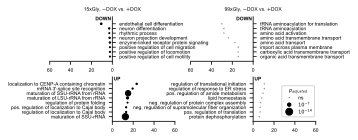

In [12]:
# number of up and down GO terms to display
NUM_TERMS = 8
# x-axis limit for GO term enrichment ratio
ENRICHMENT_MAX = 60
# GO term enrichment adjusted p value cutoff for significance
GO_P_CUTOFF = 0.01

fig, axs = plt.subplot_mosaic(
    "APWMCQX;YPBMZQD",
    figsize=(4.8, 1.9),
    gridspec_kw={
        "height_ratios": [1, 1],
        "width_ratios": [1, 0, 1, 0.25, 1, 0, 1],
    },
)

# helper function to generate open/closed points with size according to p value
enrichment_marker_style = (
    lambda p: {"ms": -np.log10(p) / 2, "marker": "o"}
    if p <= GO_P_CUTOFF
    else {
        "mew": 0.5,
        "mec": "gray",
        "mfc": "white",
        "ms": -np.log10(GO_P_CUTOFF) / 2,
        "marker": "o",
    }
)

for res, key, direction in zip(
    (res_15_down, res_15_up, res_99_down, res_99_up),
    ("A", "B", "C", "D"),
    ("DOWN", "UP", "DOWN", "UP"),
):
    ax = axs[key]
    # sort GO terms by enrichment ratio, with signficantly enriched terms at the top
    df = (
        res.assign(significant=lambda x: x.p_adj < GO_P_CUTOFF)
        .query("namespace == 'BP' and count > 2")
        .sort_values(["significant", "ratio"], ascending=[False, False])
        .iloc[:NUM_TERMS]
    )

    for i, row in enumerate(df.itertuples()):
        ax.plot([row.ratio], [-i], **enrichment_marker_style(row.p_adj), c="k")

    ax.set_ylim((-NUM_TERMS, 1.5))
    ax.set_yticks(
        range(0, -NUM_TERMS, -1),
        [GO_abbrev[x] if x in GO_abbrev else x for x in df["term"].to_list()],
    )
    ax.yaxis.set_tick_params(labelsize=5)
    ax.spines["top"].set_visible(False)

    if direction == "DOWN":
        ax.yaxis.tick_right()
        ax.set_xlim((ENRICHMENT_MAX, 0))
        ax.spines["left"].set_visible(False)
        ax.text(
            0.98,
            1,
            direction,
            transform=ax.transAxes,
            ha="right",
            va="top",
            weight="bold",
        )
    else:
        ax.set_xlim((0, ENRICHMENT_MAX))
        ax.spines["right"].set_visible(False)
        ax.text(
            0.02,
            1,
            direction,
            transform=ax.transAxes,
            ha="left",
            va="top",
            weight="bold",
        )

axs["D"].legend(
    handles=[
        Line2D([0], [0], lw=0, **enrichment_marker_style(1), c="k", label="ns"),
        Line2D(
            [0],
            [0],
            lw=0,
            **enrichment_marker_style(10**-7),
            c="k",
            label="$10^{-7}$"
        ),
        Line2D(
            [0],
            [0],
            lw=0,
            **enrichment_marker_style(10**-14),
            c="k",
            label="$10^{-14}$"
        ),
    ],
    title="$p_{adjusted}$",
    bbox_to_anchor=(0.98, 0.1),
    borderpad=0.5,
    borderaxespad=0,
    loc="lower right",
)

for ax in map(axs.get, list("MWXYZ")):
    ax.set_visible(False)
for ax in map(axs.get, list("PQ")):
    for k in ax.spines:
        ax.spines[k].set_visible(False)
    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)

axs["P"].set_title("15xGly, $-$DOX vs. $+$DOX", fontdict={"fontsize": 5})
axs["Q"].set_title("99xGly, $-$DOX vs. $+$DOX", fontdict={"fontsize": 5})
plt.subplots_adjust(hspace=0.35, wspace=0)

# Counts for tRNA ligase complex components

In [13]:
deg_15_data = pd.read_csv(
    os.path.join(PATH_R_OUTPUT, "./repeats15x.dayD14.txt"), sep="\t", index_col=0
)
deg_99_data = pd.read_csv(
    os.path.join(PATH_R_OUTPUT, "./repeats99x.dayD14.txt"), sep="\t", index_col=0
)

In [14]:
ensembl = [
    "ENSG00000171262",
    "ENSG00000100220",
    "ENSG00000079785",
    "ENSG00000087302",
    "ENSG00000135974",
]
titles = [
    r"$\it{FAM98B}$",
    r"$\it{RTCB}$",
    r"$\it{DDX1}$",
    r"$\it{RTRAF}$",
    r"$\it{C2orf49}$ (Ashwin)",
]
ensembl2symbol = dict(zip(ensembl, titles))

In [15]:
counts = deg_15_data.loc[
    list(ensembl2symbol.keys()), samples.index.map(lambda x: x + ".norm")
]
counts.columns = counts.columns.map(lambda x: x.split(".norm")[0])

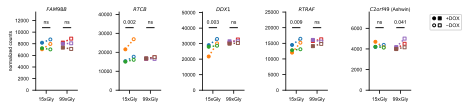

In [16]:
nrows = 1
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(6.6, 1.5))

repeats_map = {"15x": "15xGly", "99x": "99xGly"}
day_map = {"D0": "+DOX", "D14": "-DOX"}
x = {
    "15x": 0.5,
    "99x": 1.5,
    "D0": -0.2,
    "D14": 0.2,
}

for i in range(nrows * ncols):
    ax = axs[i]

    if i >= len(counts):
        ax.axis("off")
        continue

    for r in ("15x", "99x"):
        idx = samples[samples["repeats"] == r].index
        ax.scatter(
            (
                samples.loc[idx, "repeats"].map(x) + samples.loc[idx, "day"].map(x)
            ).to_list(),
            counts.iloc[i][idx].to_list(),
            edgecolors=samples.loc[idx]["clone"].map(color).to_list(),
            marker=marker[r],
            facecolors=samples.loc[idx]
            .apply(lambda x: color[x["clone"]] if fill[x["day"]] else "w", axis=1)
            .to_list(),
            s=9,
            zorder=2,
        )

    seen = set()
    for clone in [c for c in samples["clone"].values if not (c in seen or seen.add(c))]:
        d0 = samples.loc[(samples["clone"] == clone) & (samples["day"] == "D0")].iloc[
            0, :
        ]
        d14 = samples.loc[(samples["clone"] == clone) & (samples["day"] == "D14")].iloc[
            0, :
        ]
        ax.plot(
            [x[d0["repeats"]] + x["D0"], x[d0["repeats"]] + x["D14"]],
            [counts.iloc[i].loc[d0.name], counts.iloc[i].loc[d14.name]],
            c=color[d0["clone"]],
            linestyle="dotted",
            zorder=1,
        )

    ax.set_xticks([x["15x"], x["99x"]])
    ax.set_xticklabels(["15xGly", "99xGly"])
    ax.set_xlim([0, 2])
    ylim = ax.get_ylim()
    ylim = 0, ylim[1] * 1.5
    ax.set_ylim(ylim)

    if i == 0:
        ax.set_ylabel("normalized counts", labelpad=2)

    for r, res in zip(("15x", "99x"), (deg_15_data, deg_99_data)):
        ax.hlines(
            ylim[0] + (ylim[1] - ylim[0]) * 0.8,
            x[r] + x["D0"],
            x[r] + x["D14"],
            color="k",
            linewidth=1,
        )
        p = res.loc[counts.iloc[i].name]["pvalue"]
        ax.text(
            x[r],
            ylim[0] + (ylim[1] - ylim[0]) * 0.85,
            f"{p:.3f}" if p < 0.05 else "ns",
            ha="center",
        )

    ax.set_title(ensembl2symbol[counts.index[i]], pad=0, fontdict={"fontsize": 5})
    sns.despine(ax=ax)

fig.align_ylabels()
plt.legend(
    # circle and square marker for each DOX status
    [
        (
            mlines.Line2D([], [], color="k", marker="o", linestyle="none", ms=3),
            mlines.Line2D([], [], color="k", marker="s", linestyle="none", ms=3),
        ),
        (
            mlines.Line2D(
                [], [], color="k", marker="o", linestyle="none", mfc="none", ms=3
            ),
            mlines.Line2D(
                [], [], color="k", marker="s", linestyle="none", mfc="none", ms=3
            ),
        ),
    ],
    # corresponding labels
    ["+DOX", "−DOX"],
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.25)},
    bbox_to_anchor=(1.4, 1),
    loc="upper left",
)

plt.tight_layout()
plt.subplots_adjust(wspace=1)

# Session info

In [17]:
import session_info

session_info.show()